In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
val_dataset = coco.CocoDataSet('./COCO2017/', 'val',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(800, 1024))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


#### display a sample

In [5]:
img, img_meta, bboxes, labels = val_dataset[0]
rgb_img = np.round(img + img_mean)

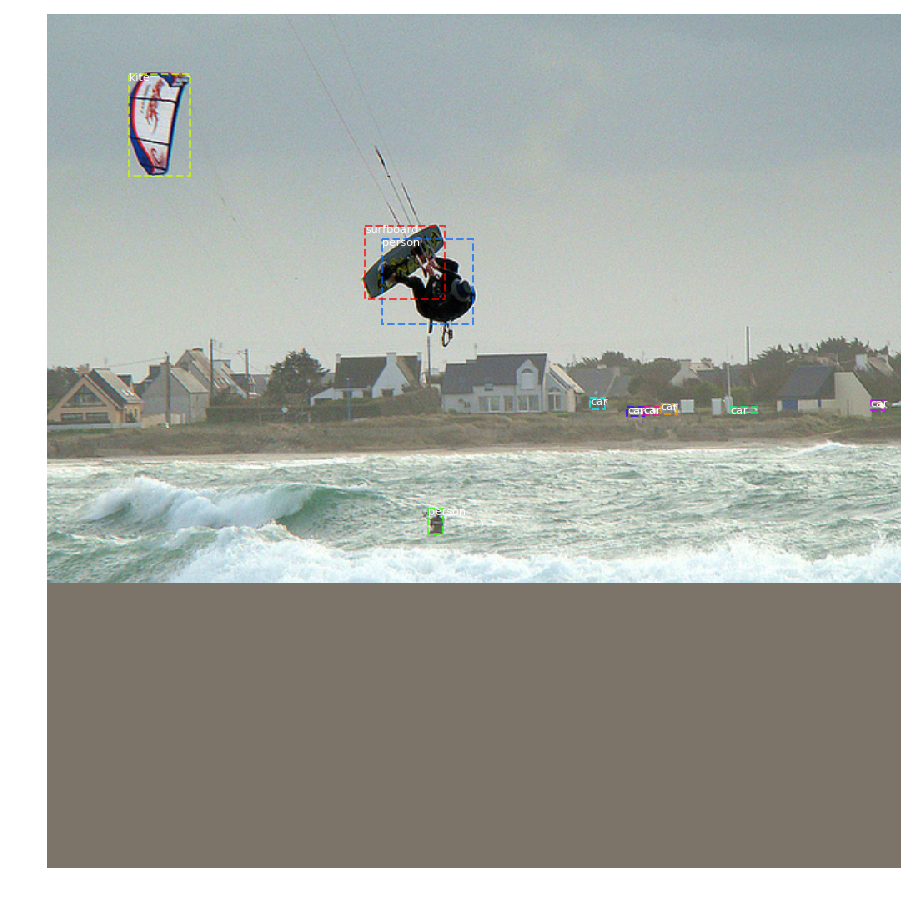

In [6]:
visualize.display_instances(rgb_img, bboxes, labels, val_dataset.get_categories())

#### load model

In [7]:
from detection.models.detectors import faster_rcnn

model = faster_rcnn.FasterRCNN(
    num_classes=len(val_dataset.get_categories()))

In [8]:
batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))
batch_bboxes = tf.Variable(np.expand_dims(bboxes, 0))
batch_labels = tf.Variable(np.expand_dims(labels, 0))

_ = model((batch_imgs, batch_metas), training=False)

In [9]:
model.load_weights('weights/faster_rcnn.h5')

### Stage 1: Region Proposal Network

#### 1.a RPN Targets

In [10]:
anchors, valid_flags = model.rpn_head.generator.generate_pyramid_anchors(batch_metas)

rpn_target_matchs, rpn_target_deltas = model.rpn_head.anchor_target.build_targets(
                anchors, valid_flags, batch_bboxes, batch_labels)

In [11]:
positive_anchors = tf.gather(anchors, tf.where(tf.equal(rpn_target_matchs, 1))[:, 1])
negative_anchors = tf.gather(anchors, tf.where(tf.equal(rpn_target_matchs, -1))[:, 1])
neutral_anchors = tf.gather(anchors, tf.where(tf.equal(rpn_target_matchs, 0))[:, 1])
positive_target_deltas = rpn_target_deltas[0, :tf.where(tf.equal(rpn_target_matchs, 1)).shape[0]]

In [12]:
from detection.core.bbox import transforms
    
refined_anchors = transforms.delta2bbox(
    positive_anchors, positive_target_deltas, (0., 0., 0., 0.), (0.1, 0.1, 0.2, 0.2))

In [13]:
print('rpn_target_matchs:\t', rpn_target_matchs[0].shape.as_list())
print('rpn_target_deltas:\t', rpn_target_deltas[0].shape.as_list())
print('positive_anchors:\t', positive_anchors.shape.as_list())
print('negative_anchors:\t', negative_anchors.shape.as_list())
print('neutral_anchors:\t', neutral_anchors.shape.as_list())
print('refined_anchors:\t', refined_anchors.shape.as_list())

rpn_target_matchs:	 [261888]
rpn_target_deltas:	 [256, 4]
positive_anchors:	 [10, 4]
negative_anchors:	 [246, 4]
neutral_anchors:	 [261632, 4]
refined_anchors:	 [10, 4]


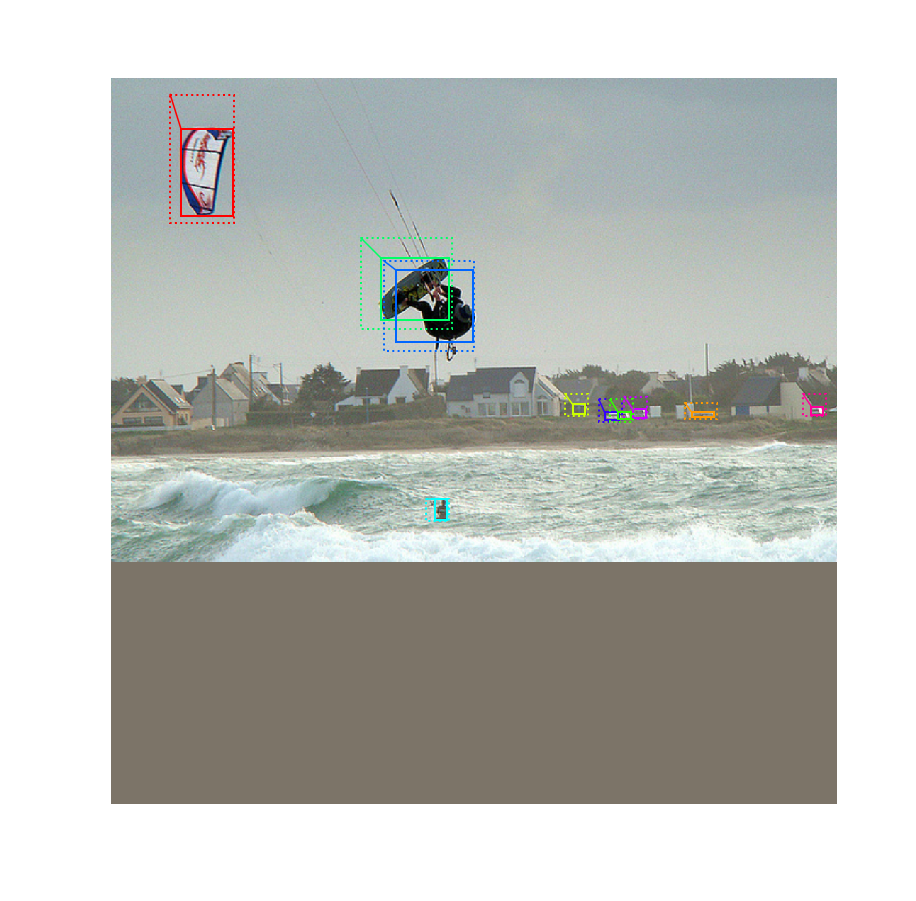

In [14]:
visualize.draw_boxes(rgb_img, 
                     boxes=positive_anchors.numpy(), 
                     refined_boxes=refined_anchors.numpy())

#### 1.b RPN Predictions

In [15]:
training = False
C2, C3, C4, C5 = model.backbone(batch_imgs, 
                                training=training)

P2, P3, P4, P5, P6 = model.neck([C2, C3, C4, C5], 
                                training=training)

rpn_feature_maps = [P2, P3, P4, P5, P6]
rcnn_feature_maps = [P2, P3, P4, P5]

rpn_class_logits, rpn_probs, rpn_deltas = model.rpn_head(
    rpn_feature_maps, training=training)

In [16]:
rpn_probs_tmp = rpn_probs[0, :, 1]

In [17]:
# Show top anchors by score (before refinement)
limit = 100
ix = tf.nn.top_k(rpn_probs_tmp, k=limit).indices[::-1]


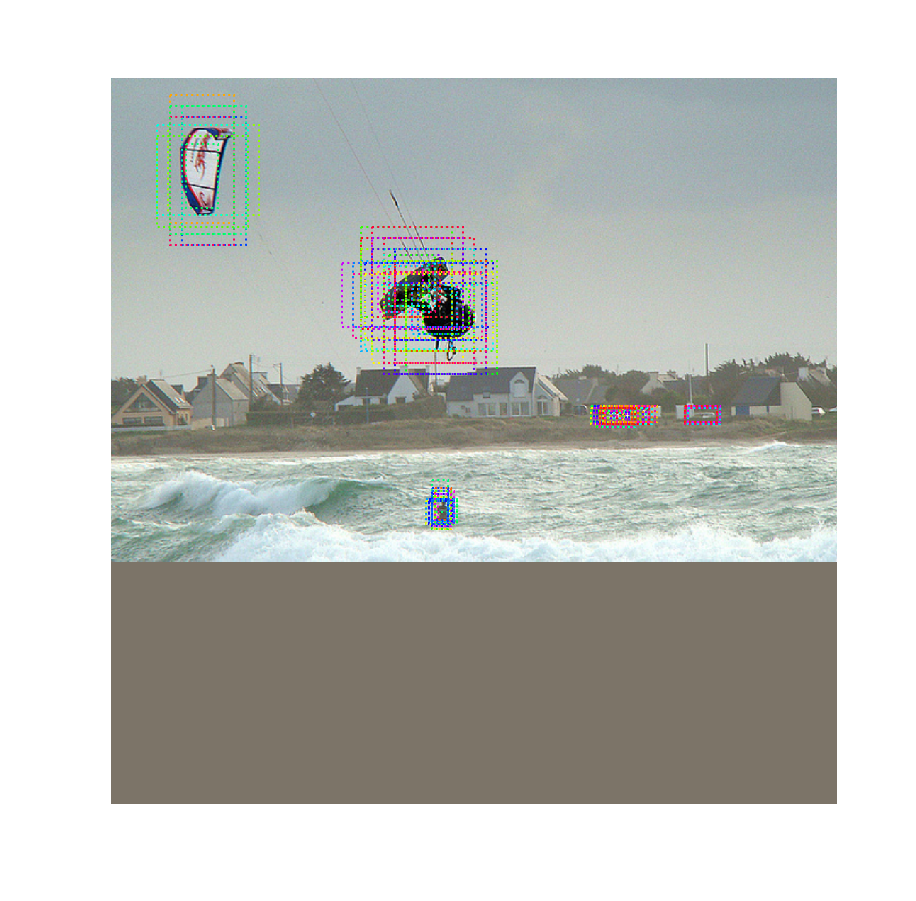

In [18]:
visualize.draw_boxes(rgb_img, boxes=tf.gather(anchors, ix).numpy())

### Stage 2:  Proposal Classification

In [19]:
proposals = model.rpn_head.get_proposals(
    rpn_probs, rpn_deltas, batch_metas)

In [20]:
rois = proposals

pooled_regions = model.roi_align(
    (rois, rcnn_feature_maps, batch_metas), training=training)

rcnn_class_logits, rcnn_probs, rcnn_deltas = \
    model.bbox_head(pooled_regions, training=training)


In [21]:
detections_list = model.bbox_head.get_bboxes(
    rcnn_probs, rcnn_deltas, rois, batch_metas)

In [22]:
tmp = detections_list[0][:, :4]

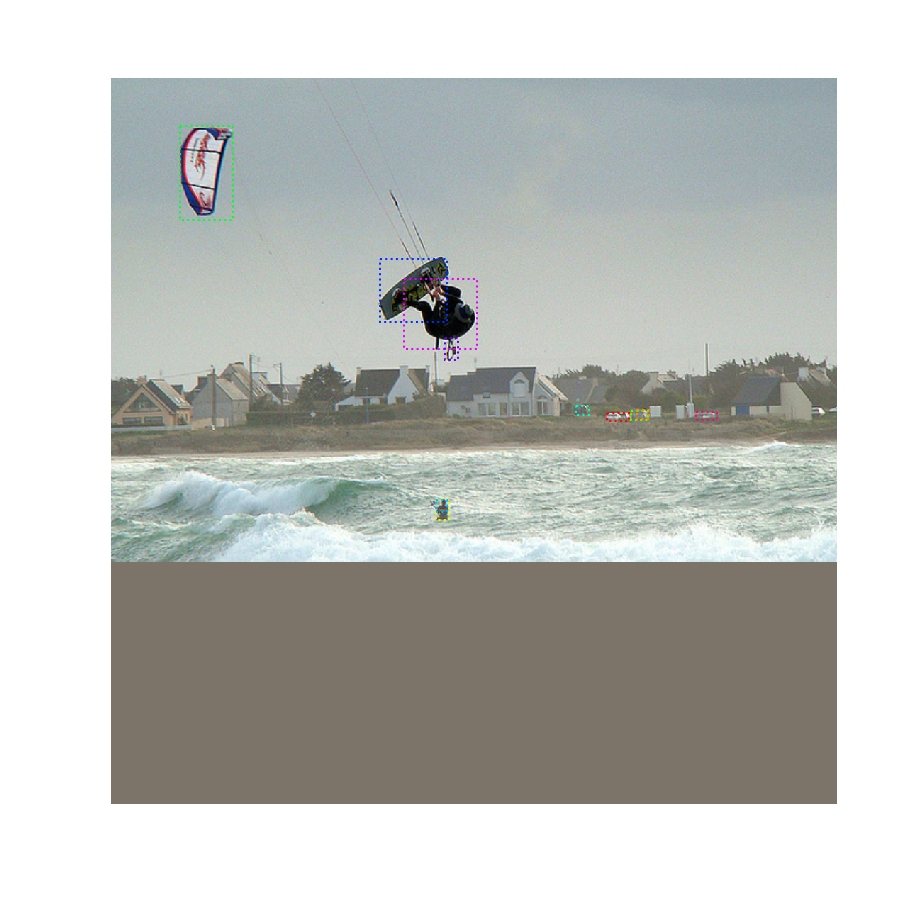

In [23]:
visualize.draw_boxes(rgb_img, boxes=tmp.numpy())

### Stage 3: Run model directly

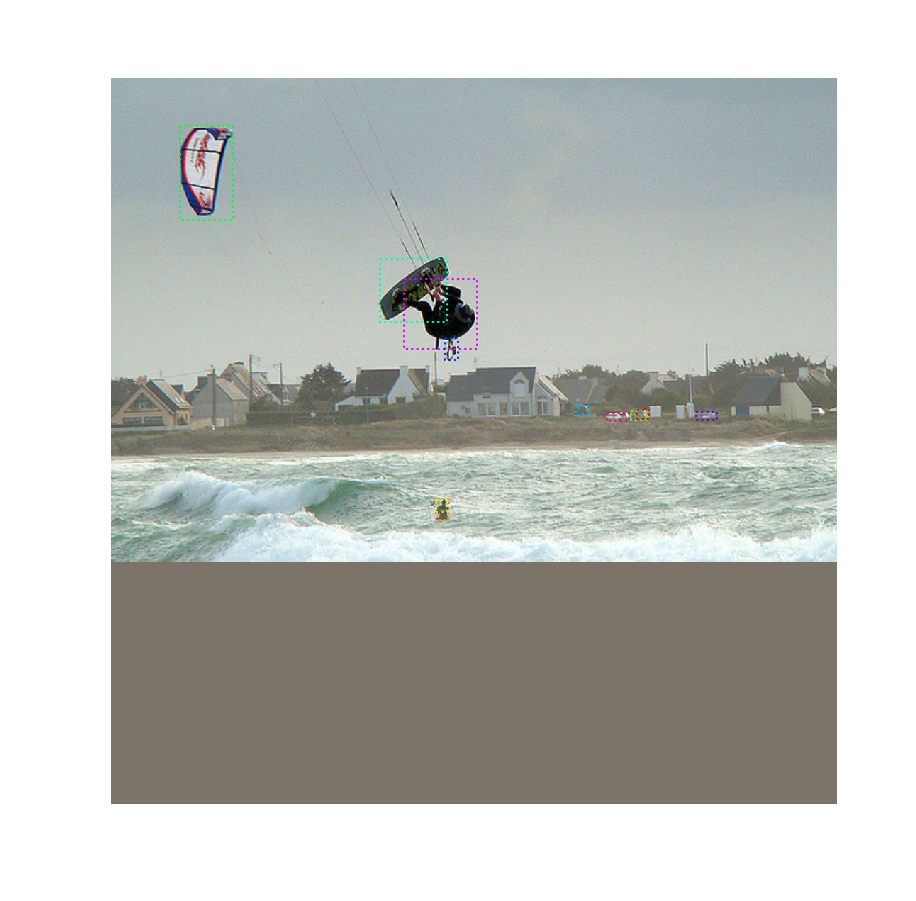

In [24]:
detections_list = model((batch_imgs, batch_metas), training=training)
tmp = detections_list[0][:, :4]
visualize.draw_boxes(rgb_img, boxes=tmp.numpy())

### Stage 4: Test (Detection)

In [25]:
from detection.datasets.utils import get_original_image
ori_img = get_original_image(img, img_meta, img_mean)

In [26]:
proposals = model.simple_test_rpn(img, img_meta)

In [27]:
res = model.simple_test_bboxes(img, img_meta, proposals)

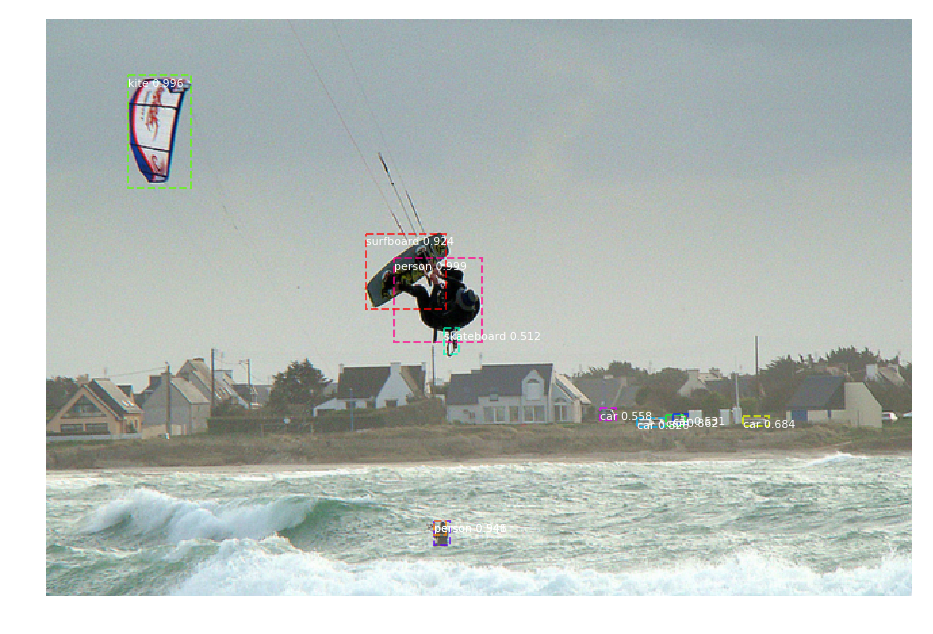

In [28]:
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            val_dataset.get_categories(), scores=res['scores'])